# MLops Project


### Overview
Part of the course - [project](https://github.com/DataTalksClub/mlops-zoomcamp/blob/main/07-project/README.md)

This project aims to forecast France's energy consumption using time serie modelin


### Data Sources
- **RTE (Réseau de Transport d'Électricité)**: The primary source for energy consumption data in France. To access the data, you need to create an account.
  - [RTE Data Access](https://www.services-rte.com/en/download-data-published-by-rte.html?category=consumption&type=energy_consumption)

- **Open-Meteo**: Provides weather data that will be used to predict energy consumption.
  - [Open-Meteo](https://open-meteo.com/)

---


In [ ]:
Dependencies to install
!pip install openmeteo-requests requests-cache retry-requests numpy pandas skforecast

### DATA PREPARTION

In [ ]:
import pandas  as pd

input_data=None
years=[2022,2023]

def get_input_data( year: int):
  daily_cons = pd.read_excel(f'drive/MyDrive/mlops_data/consumptions/daily_{year}.xls', skiprows=17,  usecols=lambda x: x if not x.startswith('Unnamed') else None)
  daily_cons.dropna(inplace=True)
  daily_cons.reset_index(inplace=True,drop=True)
  daily_cons.drop(['Type de données'],inplace=True, axis=1)
  daily_cons.rename(columns={'Energie journalière (MWh)': "MWh"},inplace=True)
  daily_cons.rename(columns={'Date': "date"},inplace=True)
  daily_cons['date'] = pd.to_datetime(daily_cons['date'], format="%d/%m/%Y", errors='coerce')
  return daily_cons

def data_preparation(years:list):
  all_years=None
  for year in years:
    this_year = get_input_data(year)
    assert this_year.shape[0]== 365, f"Data issue => not 365 days in yer {year}"
    all_years=  pd.concat([all_years, this_year])

  all_years.set_index('date', inplace = True)
  all_years.sort_index(inplace = True)
  all_years = all_years.asfreq('D', method = 'bfill')
  return all_years


input_data = data_preparation(years)
assert int(input_data.shape[0]/len(years))==365



In [ ]:

# Split train-test
# ==============================================================================
steps = 30
data_train = input_data[:-steps]
data_test  = input_data[-steps:]

print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(10, 3.5))
data_train['MWh'].plot(ax=ax, label='train')
data_test['MWh'].plot(ax=ax, label='test')
ax.legend();



### MODELING 1:    RandomForestRegressor

In [ ]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor

# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=10),
                lags      = 6
             )
forecaster.fit(y=data_train['MWh'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=10) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2022-01-01 00:00:00'), Timestamp('2023-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 10, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-07-09 20:17:41 
Last fit date: 2024-07-09 20:17:42 
Skforecast version: 0.12.1 
Python version: 3.1

In [ ]:
# Predictions
# ==============================================================================
steps = 30
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2023-12-02    1488449.50
2023-12-03    1466627.19
2023-12-04    1454743.34
2023-12-05    1396947.40
2023-12-06    1402483.23
Freq: D, Name: pred, dtype: float64

In [ ]:
from sklearn.metrics import mean_squared_error

# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['MWh'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 30931223268.264275


In [ ]:
from skforecast.model_selection import grid_search_forecaster

# Hyperparameters: grid search
# ==============================================================================
steps = 30
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 12 # This value will be replaced in the grid search
             )

# Candidate values for lags
lags_grid = [10, 20]

# Candidate values for regressor's hyperparameters
param_grid = {
    'n_estimators': [100, 250],
    'max_depth': [3, 5, 10]
}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data_train['MWh'],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = steps,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = int(len(data_train)*0.5),
                   fixed_train_size   = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False
               )

Number of models compared: 12.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 10, 'n_estimators': 250}
  Backtesting metric: 34249043628.75192



In [ ]:
#results_grid
results_grid.iloc[11]

lags                         [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
lags_label                   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
params                {'max_depth': 10, 'n_estimators': 100}
mean_squared_error                        42000003601.309837
max_depth                                                 10
n_estimators                                             100
Name: 4, dtype: object

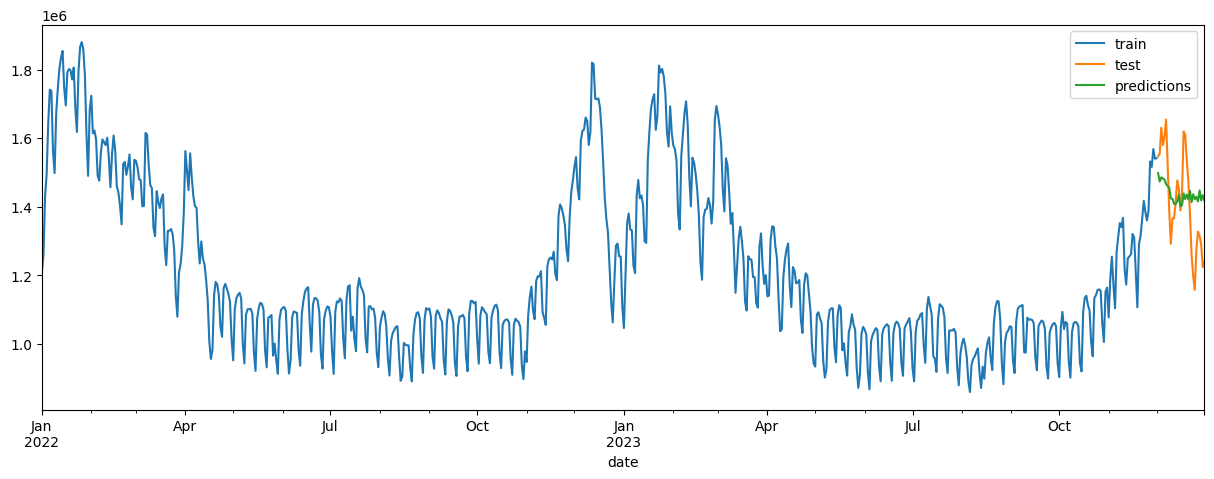

In [ ]:
# Create and train forecaster with the best hyperparameters and lags found
# ==============================================================================
regressor = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=123)
forecaster = ForecasterAutoreg(
                 regressor = regressor,
                 lags      = 10
             )
forecaster.fit(y=data_train['MWh'])
# Predictions best model
# ==============================================================================
predictions = forecaster.predict(steps=steps)

# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 5))
data_train['MWh'].plot(ax=ax, label='train')
data_test['MWh'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

### MODELING 2:   GradientBoostingRegressor

In [60]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import  GradientBoostingRegressor
import  joblib
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = GradientBoostingRegressor(random_state=10),
                lags      = 6
             )
forecaster.fit(y=data_train['MWh'])
joblib.dump(forecaster, 'forecaster_model.pkl')
forecaster

ForecasterAutoreg 
Regressor: GradientBoostingRegressor(random_state=10) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2022-01-01 00:00:00'), Timestamp('2023-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 10, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-07-09 20:50:

In [51]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from sklearn.ensemble import GradientBoostingRegressor

# Hyperparameters: grid search
# ==============================================================================
steps = 30
forecaster = ForecasterAutoreg(
                 regressor = GradientBoostingRegressor(random_state=123),
                 lags      = 12 # This value will be replaced in the grid search
             )

# Candidate values for lags
lags_grid = [10, 20]

# Candidate values for regressor's hyperparameters
param_grid = {
    'n_estimators': [100, 250],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data_train['MWh'],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = steps,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = int(len(data_train)*0.5),
                   fixed_train_size   = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False
               )

Number of models compared: 48.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/24 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 250, 'subsample': 1.0}
  Backtesting metric: 19074077227.84059



In [54]:
results_grid
results_grid.iloc[35]

lags                                    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
lags_label                              [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
params                {'learning_rate': 0.01, 'max_depth': 5, 'n_est...
mean_squared_error                                   45607008294.284149
learning_rate                                                      0.01
max_depth                                                           5.0
n_estimators                                                      250.0
subsample                                                           1.0
Name: 7, dtype: object

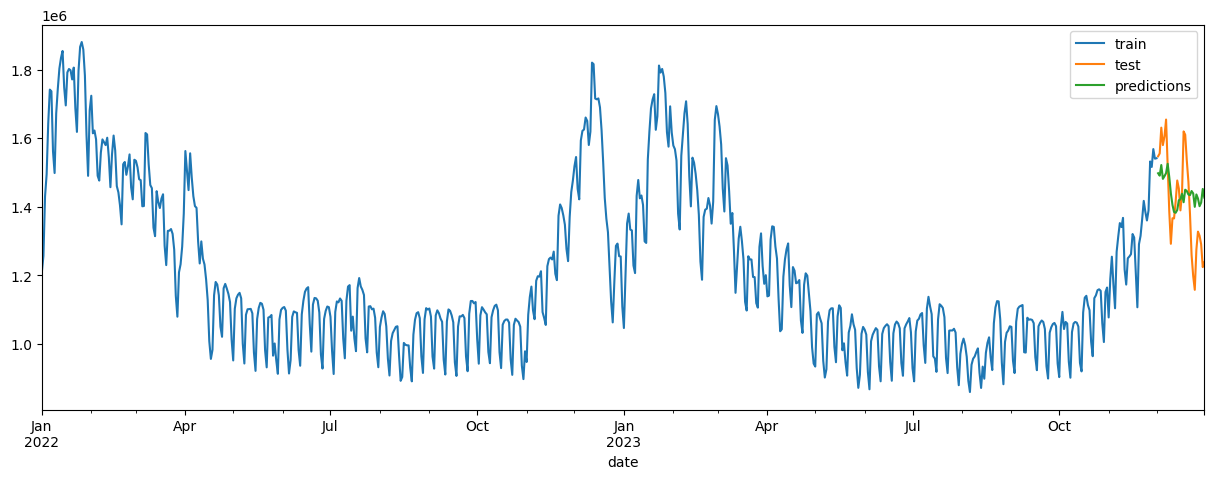

In [55]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

# Best hyperparameters found (example values, replace with actual best values from grid search)
regressor = GradientBoostingRegressor(n_estimators=250,
                                      max_depth=5,
                                      learning_rate=0.1,
                                      subsample=0.8, random_state=123)

# Create and train forecaster with the best hyperparameters and lags found
forecaster = ForecasterAutoreg(
                 regressor = regressor,
                 lags      = 10
             )
forecaster.fit(y=data_train['MWh'])

# Predictions best model
# ==============================================================================
steps = 30
predictions = forecaster.predict(steps=steps)

# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 5))
data_train['MWh'].plot(ax=ax, label='train')
data_test['MWh'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()
plt.show()


In [56]:
from sklearn.metrics import mean_squared_error

# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['MWh'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 16261773866.004297


https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html

In [61]:
from sklearn.feature_extraction import DictVectorizer

# Sample data: list of dictionaries
data = [
    {'city': 'New York', 'temperature': 23},
    {'city': 'San Francisco', 'temperature': 18},
    {'city': 'Chicago', 'temperature': 20},
    {'city': 'New York', 'temperature': 21}
]

# Create a DictVectorizer instance
vec = DictVectorizer(sparse=True)

# Fit and transform the data
data_matrix = vec.fit_transform(data)

# Display the feature names
print(vec.get_feature_names_out())

# Convert the sparse matrix to a dense array for display purposes
print(data_matrix.toarray())

['city=Chicago' 'city=New York' 'city=San Francisco' 'temperature']
[[ 0.  1.  0. 23.]
 [ 0.  0.  1. 18.]
 [ 1.  0.  0. 20.]
 [ 0.  1.  0. 21.]]
